# Vorlesung 4: Strukturen von Texten 2

Reguläre Ausdrücke: http://www.regexe.de/hilfe.jsp
                    https://pymotw.com/2/re

Pandas: http://www.data-analysis-in-python.org/3_pandas.html
      : https://bitbucket.org/hrojas/learn-pandas



In [1]:
import json
import pandas as pd
import re
import numpy as np
import requests

## Construct Dataframe from full Poleis data

In [2]:
PoleisDataOnline2 = requests.get('http://repository.edition-topoi.org/MISC/ReposMISC/MISC00005/secondVersion.json')
PoleisRawData2 = PoleisDataOnline2.json()
PoleisRawData2.keys()

dict_keys(['Lesbos', 'Arkadia', 'Thrace from Axios to Strymon', 'Boiotia', 'The Saronic Gulf', 'The South Coast of Asia Minor (Pamphylia Kilikia)', 'Attika', 'Messenia', 'The Propontic Coast of Asia Minor', 'Spain and France (including Corsica)', 'Megaris, Korinthia, Sikyonia', 'Argolis', 'Thrace from Nestos to Hebros', 'Karia', 'Rhodos', 'Triphylia', 'Thracian Chersonesos', 'Akarnania and Adjacent Areas', 'Thrace from Strymon to Nestos', 'Cyprus', 'Propontic Thrace', 'Aiolis and South-western Mysia', 'The Aegean', 'Epeiros', 'Lykia', 'Italia and Kampania', 'Makedonia', 'Phokis', 'East Lokris', 'Doris', 'Crete', 'Sikelia', 'Troas', 'Lakedaimon', 'The Black Sea Area', 'West Lokris', 'Achaia', 'Euboia', 'Ionia', 'Aitolia', 'Elis', 'Thessalia and Adjacent Regions', 'Inland Thrace', 'The Adriatic'])

In [3]:
# Read Json into a normalized form, yields ~500 columns with region.city keys
dfPoleisGesamt = pd.io.json.json_normalize(PoleisRawData2)

# rotate and rename dataframe
dfPoleisGesamt= dfPoleisGesamt.transpose()
dfPoleisGesamt.columns=['Beschreibung']
dfPoleisGesamt.head(4)

# reset to new index, return old index as column 'index'
dfPoleisGesamt= dfPoleisGesamt.reset_index()
dfPoleisGesamt.head()

# split entries in column 'index' into region and city part
dfPoleisGesamt['indexSplit'] = dfPoleisGesamt['index'].str.split('.')

# generate new columns out of split index
dfPoleisGesamt['region'] = dfPoleisGesamt['indexSplit'].apply(lambda raw: raw[0])
dfPoleisGesamt['city'] = dfPoleisGesamt['indexSplit'].apply(lambda raw: raw[1])
dfPoleisGesamt.head()

# remove columns 'index' and 'indexSplit', since they contain redundant information
dfPoleisGesamt = dfPoleisGesamt.drop('index', 1)
dfPoleisGesamt = dfPoleisGesamt.drop('indexSplit', 1)
dfPoleisGesamt.head()

,Beschreibung,region,city
0,"Identifier: 233. , (Ascheieus) Unlocated. Typ...",Achaia,Ascheion
1,"Identifier: 235. , (Bourios) Map 58. Lat. 38...",Achaia,Boura
2,"Identifier: 236. , (Helikeus) Map 58. Lat. 3...",Achaia,Helike
3,"Identifier: 237. , (Keryneus) Map 58. Lat. 3...",Achaia,Keryneia
4,"Identifier: 238. , (Leontesios) Map 58.Lat.38...",Achaia,Leontion


# Konstruktion neuer Merkmale
## Textmuster mit regulären Ausdrücken

http://www.regexe.de/hilfe.jsp 
https://www.cheatography.com/davechild/cheat-sheets/regular-expressions/

http://www.coli.uni-saarland.de/courses/python1-10/folien/PythonI10-07.pdf

## Textmustersuche in der Beschreibung einer Polis

### Geographische Koordinaten

In [4]:
def ListePattern(string,pattern):
    x = re.findall(pattern,string)
    if x:
        return(x)

Example for geographical coordinates:

- (?<=Lat\.\s)  Group (?...) Passive (non-capturing) group
- ?<= Lookbehind assertion
- Lat\.\s   das string muster: "Lat. " mit "." und " " als escape
- \s?\d+\.\d+ : space[optional wegen ?]digit[1 oder 2 wegen +].[escaped]digit[1 oder 2]

Code::

    dfPoleisGesamt['Latitude'] = dfPoleisGesamt['Beschreibung'].apply(lambda raw: ListePattern(raw,"(?<=Lat\.\s)\d+\.\d+"))

### Zitatnachweise, Namen, Jahreszahlen

In [5]:
dfPoleisGesamt["Beschreibung"].iloc[2] # icloc is a method to refer to local index position

"Identifier: 236. , (Helikeus) Map  58.  Lat. 38.15,long.  22.10.  Size of  territory: 1  or 2.  Type:  A.  Paus. 7.24.5  locates  Helike  40 stades  from  Aigion  (no. 231),  while  Strabo  8.7.2  (following Herakleides)  places  it  12  stades  from  the  sea.  This  should  put it  between  the  rivers  Selinous  and  Kerynitis  (Morgan  and Hall ( 1996)  175;  Barr.).  The  city,  which  was  overwhelmed  by a  tidal  wave  occasioned  by  an  earthquake  in  373  (Diod. 15.48.1\xad49.4;  Polyb. 2.41.7;Strabo 8.7.2;  Paus. 7.24.6;Ael.  NA 11.19),  was  normally  supposed  to  lie  under  water  (cf.  Ov. Met. 15.293\xad95),  but  sonar  investigation  suggests  that  it  may actually  lie  inland  under  massive  sedimentary  deposits  in the  vicinity  of  Nea  Keryneia  (Petropoulos  ( 1983);  cf.  Ptol. Geog. 3.14.36,  who  lists  Helike  among  the  inland  cities  of Achaia).  However,  Rizakis  ( 1995)  203\xad4  finds all candidates for  ancient  Helike  unconvincing.  The  

## Muster (Pattern) zur Erkennung der Literaturreferenzen

- Primärquellen

(Polyb. 1.18.2)
(Diod. 13.85.4  (r 406))
(Diod. 13.108.2)
(Hdt. 7.165;  IGDS  no. 182a)
(Pind.  Pyth. 6)
(Thuc. 6.4.4: µµ  )
(Xanthos  (FGrHist 765)  fr. 33;  Arist.  fr. 865)

- Sekundärquellen

(Karlsson  ( 1995)  161
(Waele  ( 1971) 195;  Hinz  ( 1998)  79)

- Jahreszahlen
( dddd)

### Mehrere reguläre Ausdrücke nötig, um alle Zitate zu finden

Finde alle Ausdrücke wie oben, denen ein Punkt folgt, mit anschließenden Zifferfolgen der Form [Ziffern][Punkt][Ziffern][Punkt][Ziffern]

In [6]:
dfPoleisGesamt['Beschreibung'].apply(lambda raw: ListePattern(raw,'[A-Z][a-z]{1,10}\. \d{1,3}\.\d{1,3}\.\d{1,3}'))[2]

['Paus. 7.24.5',
 'Diod. 15.48.1',
 'Polyb. 2.41.7',
 'Paus. 7.24.6',
 'Geog. 3.14.36',
 'Diod. 15.49.3',
 'Polyb. 2.41.7',
 'Diod. 15.48.3',
 'Diod. 15.49.3',
 'Polyb. 2.41.6',
 'Paus. 7.24.5']

Finde alle Ausdrücke wie oben, wobei statt des Punktes nach den kleinen Buchstaben zwei Leerzeichen und eine runde Klammer und vier Ziffern folgen können

In [7]:
dfPoleisGesamt['Beschreibung'].apply(lambda raw: ListePattern(raw,'[A-Z][a-z]{1,15}\s{0,2}\(\s*\d{4}\)'))[2]

['Hall ( 1996)',
 'Petropoulos  ( 1983)',
 'Rizakis  ( 1995)',
 'Katsonopoulou  ( 1999)',
 'Petropoulos  ( 1990)',
 'Hall  ( 1996)',
 'Aymard  ( 1938)',
 'Walbank ( 2000)']

Finde alle Authoren, gefolgt von einem oder mehreren Leerzeichen und ([Ziffer][Punkt][Ziffern][Punkt][Ziffern])

In [8]:
dfPoleisGesamt['Beschreibung'].apply(lambda raw: ListePattern(raw,'[A-Z][a-z]{1,15}\s{0,2}\(\s*\d{1,2}\.\d{1,2}\.\d{1,2}\)'))[2]

Wie oben nur ohne Klammern.

In [9]:
dfPoleisGesamt['Beschreibung'].apply(lambda raw: ListePattern(raw,'[A-Z][a-z]{1,15}\s{0,2}\s*\d{1,2}\.\d{1,2}\.\d{1,2}'))[2]

['Strabo  8.7.2', 'Strabo 8.7.2', 'Strabo  8.7.2', 'Strabo  6.1.13']

In [10]:
dfPoleisGesamt['Beschreibung'].apply(lambda raw: ListePattern(raw,'[A-Z][a-z]{1,15}\.\s+[A-Z][a-z]{1,10}\.\s+[A-Za-z]{1,10}\.\s+\d{1,3}\.\d{1,3}'))[2]

['Theophr.  Phys.  Op. 12.122', 'Theophr.  Phys.  op. 12.122']

In [11]:
dfPoleisGesamt['Beschreibung'].apply(lambda raw: ListePattern(raw,'[A-Z][a-z]{1,15}\.\s+[A-Z][a-z]{1,10}\.\s+\d{1,3}\.\d{1,3}'))[2]

['Ov. Met. 15.293',
 'Ptol. Geog. 3.14',
 'Hom.  Il. 2.575',
 'Phys.  Op. 12.122',
 'Hom. Il. 2.575',
 'Hom.  Il. 8.203']

In [12]:
# Zusammenfassen von zwei Bedingungen: kompilieren des regulären Ausdrucks beschleunigt den Suchprozess

pat = re.compile('([A-Z][a-z]{1,10}\. \d{1,3}\.\d{1,3}\.\d{1,3}|[A-Z][a-z]{1,15}\s{0,2}\(\s*\d{4}\)|[A-Z][a-z]{1,15}\s{0,2}\(\s*\d{1,2}\.\d{1,2}\.\d{1,2}\)|[A-Z][a-z]{1,15}\s{0,2}\s*\d{1,2}\.\d{1,2}\.\d{1,2}|[A-Z][a-z]{1,15}\.\s+[A-Z][a-z]{1,10}\.\s+[A-Za-z]{1,10}\.\s+\d{1,3}\.\d{1,3}|[A-Z][a-z]{1,15}\.\s+[A-Z][a-z]{1,10}\.\s+\d{1,3}\.\d{1,3})')

dfPoleisGesamt['Beschreibung'].apply(lambda raw: ListePattern(raw,pat))[2]

['Paus. 7.24.5',
 'Strabo  8.7.2',
 'Hall ( 1996)',
 'Diod. 15.48.1',
 'Polyb. 2.41.7',
 'Strabo 8.7.2',
 'Paus. 7.24.6',
 'Ov. Met. 15.293',
 'Petropoulos  ( 1983)',
 'Ptol. Geog. 3.14',
 'Rizakis  ( 1995)',
 'Hom.  Il. 2.575',
 'Theophr.  Phys.  Op. 12.122',
 'Diod. 15.49.3',
 'Theophr.  Phys.  op. 12.122',
 'Polyb. 2.41.7',
 'Diod. 15.48.3',
 'Diod. 15.49.3',
 'Polyb. 2.41.6',
 'Hom. Il. 2.575',
 'Katsonopoulou  ( 1999)',
 'Petropoulos  ( 1990)',
 'Hom.  Il. 8.203',
 'Strabo  8.7.2',
 'Paus. 7.24.5',
 'Hall  ( 1996)',
 'Aymard  ( 1938)',
 'Walbank ( 2000)',
 'Strabo  6.1.13']

In [13]:
pat = re.compile('([A-Z][a-z]{1,10}\. \d{1,3}\.\d{1,3}\.\d{1,3}|[A-Z][a-z]{1,15}\s{0,2}\(\s*\d{4}\)|[A-Z][a-z]{1,15}\s{0,2}\(\s*\d{1,2}\.\d{1,2}\.\d{1,2}\)|[A-Z][a-z]{1,15}\s{0,2}\s*\d{1,2}\.\d{1,2}\.\d{1,2}|[A-Z][a-z]{1,15}\.\s+[A-Z][a-z]{1,10}\.\s+[A-Za-z]{1,10}\.\s+\d{1,3}\.\d{1,3}|[A-Z][a-z]{1,15}\.\s+[A-Z][a-z]{1,10}\.\s+\d{1,3}\.\d{1,3}[A-Za-z]{1,10}.?\s+[¹²³]\d+\.\d+|[A-Za-z]{1,10}.?\s+[¹²³]\d+|[A-Za-z]{1,10}.?\s+\d+\s+\d+)')

dfPoleisGesamt['Quellen'] = dfPoleisGesamt['Beschreibung'].apply(lambda raw: ListePattern(raw,pat))

In [14]:
dfPoleisGesamt.head(10)

,Beschreibung,region,city,Quellen
0,"Identifier: 233. , (Ascheieus) Unlocated. Typ...",Achaia,Ascheion,None
1,"Identifier: 235. , (Bourios) Map 58. Lat. 38...",Achaia,Boura,"[Paus. 7.25.8, Strabo 8.7.5, Hall ( 1996), R..."
2,"Identifier: 236. , (Helikeus) Map 58. Lat. 3...",Achaia,Helike,"[Paus. 7.24.5, Strabo 8.7.2, Hall ( 1996), Di..."
3,"Identifier: 237. , (Keryneus) Map 58. Lat. 3...",Achaia,Keryneia,"[Paus. 7.25.5, Rizakis ( 1995), Paus. 7.25.5,..."
4,"Identifier: 238. , (Leontesios) Map 58.Lat.38...",Achaia,Leontion,"[Lauffer ( 1989), SEG 15 254, Polyb. 2.41.7,..."
5,"Identifier: 241. , (Olenios) Map 58. Lat. 38...",Achaia,Olenos,"[Paus. 7.18.1, Strabo 8.7.4, Rizakis ( 1995)..."
6,"Identifier: 244. , (Pharaieus) Map 58. Lat. ...",Achaia,Pharai,"[Paus. 7.22.1, Rizakis ( 1995), Polyb. 2.41.8,..."
7,"Identifier: hall, (Tritaieus) Map 58.Lat.37.5...",Achaia,Tritaia,"[Paus. 7.22.6, Rizakis ( 1995), Polyb. 2.41.8..."
8,"Identifier: 801. , (Adramytenos) Map 56. Lat...",Aiolis and South-western Mysia,Adramyttion,"[Hdt. 7.42.1, An. 7.8.8, Thuc. 5.1.1, Fossey ..."
9,"Identifier: 802. , (Aigaieus) Map 56. Lat. 3...",Aiolis and South-western Mysia,Aigai(ai),"[Hdt. 1.149.1, Strabo 13.3.5, Hell. 4.8.5, HN ..."


# Datenvalidierung

## Bewertung des Modells mit Performanz- (Konfusions-)matrix

Volle beschreibung für eine Stadt. Quellen per Hand markiert.

In [15]:
#dfPoleisGesamt['Beschreibung'].iloc[2]

"Identifier: 236. , (Helikeus) Map  58.  Lat. 38.15,long.  22.10.  Size of  territory: 1  or 2.  Type:  A.  **Paus. 7.24.5**  locates  Helike  40 stades  from  Aigion  (no. 231),  while  **Strabo  8.7.2**  (following Herakleides)  places  it  12  stades  from  the  sea.  This  should  put it  between  the  rivers  Selinous  and  Kerynitis  (**Morgan  and Hall ( 1996)  175;  Barr.)**.  The  city,  which  was  overwhelmed  by a  tidal  wave  occasioned  by  an  earthquake  in  373  (**Diod. 15.48.1\xad49.4;  Polyb. 2.41.7;Strabo 8.7.2;  Paus. 7.24.6;Ael.  NA 11.19**),  was  normally  supposed  to  lie  under  water  (cf.  **Ov. Met. 15.293\xad95**),  but  sonar  investigation  suggests  that  it  may actually  lie  inland  under  massive  sedimentary  deposits  in the  vicinity  of  Nea  Keryneia  (**Petropoulos  ( 1983);  cf.  Ptol. Geog. 3.14.36**,  who  lists  Helike  among  the  inland  cities  of Achaia).  However,  **Rizakis  ( 1995)  203\xad4**  finds all candidates for  ancient  Helike  unconvincing.  The  toponym  is  usually **`,  (Hom.  Il. 2.575;  SEG 36  718  (C 5e);  Hdt. 1.145)  or `  (Syll. ³90.12)**,  though  **Theophr.  Phys.  Op. 12.122**  cites a  verse  which  gives  the  toponym  as  `.  The  city- ethnic  is  `  **(Diod. 15.49.3)**. Helike  is  called  a  polis  in  the  urban  sense  in  **Heraclid. Pont.  fr. 46a  (r 373)**  and  **Theophr.  Phys.  op. 12.122  (r 373)**,but  is absent  from  Ps.-Skylax's  list  of  Achaian  poleis  ( 42),  which may  suggest  that  this  chapter  was  composed  after  373. Retrospective  evidence  is  provided  by  **Polyb. 2.41.7  (rC 4)**, who  calls  it  a  polis  in  the  political  sense,  and  by  **Diod. 15.48.3 (r 373)**,  who  describes  it  as  a  polis  in  the  urban  sense.  The internal  collective  use  of  the  city-ethnic  is  probably  found (abbreviated)  on  C 4  coins  (infra),  and  the  external  collective use  is  found  in  **Diod. 15.49.3**  (r  ante 373).  A  citizen  of  Helike served  as  Delphic  theorodokos  in  C 5l  **(Syll. ³90.12)**.According to **Polyb. 2.41.6\xad7**  (rC 4),  Helike  had  been  a  member  of  the Achaian  Confederacy. The  early  physical  existence  of  Helike  is  attested  in  **Hom. Il. 2.575**  and  in  a  C 5e  inscription  (**SEG 36  718**;  see  also  **Soter and  Katsonopoulou  ( 1999)**).  Archaeological  investigations have  revealed  the  foundations  of  two  small  temples,  one Archaic,  the  other  Classical,  at  Nea  Keryneia,  which  may possibly  be  associated  with  the  acropolis  of  ancient  **Helike (Petropoulos  ( 1990)**).  The  most  important  sanctuary  at Helike  was,  however,  that  of  Poseidon  Helikonios  **(Hom.  Il. 8.203;Diod.  15.49.2\xad3;Strabo  8.7.2;  Paus. 7.24.5\xad6)**,  and  it  is quite  likely  that  this  sanctuary  acted  as  a  common  place  of union  for  the  Achaians  prior  to  the  destruction  of Helike,  when  that  function  was  assumed  by  the  sanctuary of  Zeus  Homarios  near  Aigion  **(Morgan  and  Hall  ( 1996) 195\xad96,  contra  Aymard  ( 1938)  286\xad87,  293;  Walbank ( 2000))**. According  to  **Strabo  6.1.13**,  Is  of  Helike  was  the  founder  of Sybaris  (no. 70)  in  South  Italy.  The  reading  (  '  &lt;...  &gt; ) is,  however,  unsure,  and **Bérard  ( 1957)**  141  n. 2  proposed  either  &lt; &gt;  or &lt; &gt;. A  series  of  bronze  coins,  dating  to  C 4f,  depicts  obv.  head of  Poseidon.  Legend: (retr.).  Rev.  trident  between dolphins  in  wreath  **(Head,  HN ²414)**. 236. "

Gefundene Quellen

In [16]:
dfPoleisGesamt['Quellen'].iloc[2]

['Paus. 7.24.5',
 'Strabo  8.7.2',
 'Hall ( 1996)',
 'Diod. 15.48.1',
 'Polyb. 2.41.7',
 'Strabo 8.7.2',
 'Paus. 7.24.6',
 'Petropoulos  ( 1983)',
 'Geog. 3.14.36',
 'Rizakis  ( 1995)',
 'SEG 36  718',
 'Syll. ³90',
 'Theophr.  Phys.  Op. 12.122',
 'Diod. 15.49.3',
 'Theophr.  Phys.  op. 12.122',
 'Polyb. 2.41.7',
 'Diod. 15.48.3',
 'Diod. 15.49.3',
 'Syll. ³90',
 'Polyb. 2.41.6',
 'SEG 36  718',
 'Katsonopoulou  ( 1999)',
 'Petropoulos  ( 1990)',
 'Strabo  8.7.2',
 'Paus. 7.24.5',
 'Hall  ( 1996)',
 'Aymard  ( 1938)',
 'Walbank ( 2000)',
 'Strabo  6.1.13',
 'HN ²414']

Diskussion der Performanzmatrix: vier Fälle
- soll match vs. tatsächlicher match
- nicht soll match vs. tatsächlich
- soll match vs. nicht tatsächlich
- nicht soll vs. nicht tatsächlich

While 29 citations are found, 10 are neglected. 
Structures not yet captured are
- citations with several capital letters (e.g. SEG 36  718)
- citations with sepcial characters (e.g. Syll. ³90.12)

2 Structures wrongly captured are
- citations with several authors are captured under one name only

To extend the search string, we used

In [17]:
re.findall('([A-Za-z]{1,10}.?\s+[¹²³]\d+\.\d+|[A-Za-z]{1,10}.?\s+[¹²³]\d+|[A-Za-z]{1,10}.?\s+\d+\s+\d+)',dfPoleisGesamt['Beschreibung'].iloc[2])

['SEG 36  718', 'Syll. ³90.12', 'Syll. ³90.12', 'SEG 36  718', 'HN ²414']

## Wertverteilungen, Test auf Dopplungen

Lese Werte der Spalte Quellen als Liste aus und reduziere Unterlisten auf eine Gesamtliste. 

In [18]:
mainList = dfPoleisGesamt['Quellen'].values.tolist()

quellenListe = []
for sublist in mainList:
    if sublist:
        for k in sublist:
            quellenListe.append(k)

In [19]:
quellenListe[:10]

['Paus. 7.25.8',
 'Strabo  8.7.5',
 'Hall  ( 1996)',
 'Rizakis ( 1995)',
 'Polyb. 2.41.13',
 'Paus. 7.25.8',
 'Theophr.  Phys.  op. 12.122',
 'Polyb. 2.41.7',
 'Diod. 15.48.3',
 'Paus. 7.25.8']

Zähle die Häufigkeit der verschiedenen Quellen und speichere als Dictionary.

In [20]:
quellenVerteilung = {x:quellenListe.count(x) for x in quellenListe}
quellenVerteilung['Diod. 14.90.3']

2

Erzeuge DataFrame, mit neuem Index und Namen der Spalten. Sortiere diesen Nach der Häufigkeit der Quelle.

In [21]:
dfQuellenVerteilung = pd.DataFrame([quellenVerteilung])
dfQuellenVerteilung

,Abmeier ( 1990),Accame ( 1941),Adamesteanu ( 1970),Adamesteanu ( 1973),Adamesteanu ( 1974),Adamesteanu ( 1976),Adamesteanu ( 1979),Adamesteanu ( 1982),Adamesteanu ( 1986),Adamesteanu ( 1979),...,regions 695 4,regions 713 434,rhodos 1205 8,"stoa, 6 26",strymon 829 578,strymon 841 607,suppl. 29 5,suppl. 29 5,xii 1 1036,xii 5 242
0,1,1,3,1,4,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [22]:
dfQuellenVerteilung = dfQuellenVerteilung.transpose().reset_index()
dfQuellenVerteilung.head()

,index,0
0,Abmeier ( 1990),1
1,Accame ( 1941),1
2,Adamesteanu ( 1970),3
3,Adamesteanu ( 1973),1
4,Adamesteanu ( 1974),4


In [23]:
dfQuellenVerteilung = dfQuellenVerteilung.rename(columns={'index': 'Quelle', 0:'Häufigkeit'})
dfQuellenVerteilung.head()

,Quelle,Häufigkeit
0,Abmeier ( 1990),1
1,Accame ( 1941),1
2,Adamesteanu ( 1970),3
3,Adamesteanu ( 1973),1
4,Adamesteanu ( 1974),4


In [24]:
dfQuellenVerteilung.sort_values(by='Häufigkeit',ascending=False).head(10)

,Quelle,Häufigkeit
3458,Jost ( 1985),71
3399,Isaac ( 1986),57
5328,Rider ( 1966),55
6999,Svoronos ( 1890),55
1776,Fossey ( 1988),52
2378,Hansen ( 1996),44
4880,Perlman ( 2000),42
5705,SEG 23 189,40
3647,Kraay ( 1976),37
3596,Knoepfler ( 1997),36


# Größere Textblöcke, mit textblob, spacy and NLTK

In [25]:
%load_ext tikzmagic

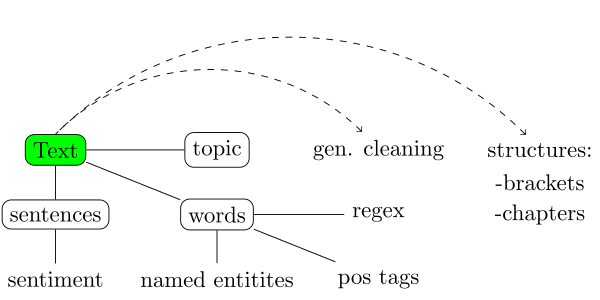

In [26]:
%%tikz --scale 2 --size 600,300 -f svg
\tikzset{boxed/.style={draw,rectangle,rounded corners, fill={#1}}}
\node[boxed=green] (text) {Text};
%
\node[boxed=white,right of=text,node distance=2.5cm] (topic) {topic};
\node[right of=topic, node distance=2.5cm] (clean) {gen. cleaning}
    edge[<-,dashed,draw,bend right=45] (text.north) ;
%
\node[right of=clean,node distance=2.5cm] (other) {structures:}
    edge[<-, dashed,draw,bend right = 45] (text.north);
\node[below of=other,node distance=0.5cm] (bra) {-brackets};
\node[below of=bra, node distance=0.5cm] (chp) {-chapters};
%
\node[boxed=white,below of=text] (sentences) {sentences};
\node[below of=sentences] (sentiment) {sentiment};
%
\node[boxed=white,below of=topic] (words) {words};
\node[below of=words] (ne) {named entitites};
\node[right of=words, node distance=2.5cm] (regex) {regex};
\node[below of=regex] (pos) {pos tags};
%
\draw[] (text) -- (topic);
%
\draw[] (text) -- (words);
\draw[] (words) -- (regex);
\draw[] (words) -- (ne);
\draw[] (words) -- (pos);
%
\draw[] (text) -- (sentences);
\draw[] (sentences) -- (sentiment);

## links

- Multi-word-expressions: MWETokenizer
- Vortrainierte sprachenabhängige tagger: NLTKTagger
- Spacy: eigener Tagger in nlp
- Klammern Tagger: SExprTokenizer
- PunktSentenceTokenizer: erkennt Sätze, kann ohne Kontrolle trainiert werden.

In [27]:
from textblob import TextBlob
from textblob.taggers import NLTKTagger

from nltk.tokenize import MWETokenizer

import spacy
nlp = spacy.en.English()

from nltk.tokenize import SExprTokenizer # Klammer Erkennung
nltk_tagger = NLTKTagger()

import nltk.data
from nltk import PunktSentenceTokenizer # Verbesserte Satzerkennung

In [28]:
text = dfPoleisGesamt['Beschreibung'].iloc[2]

## Textblob

Generate blob using TextBlob. This allows identifying different parts of a text  (words, sentences)  or tagging words with their type (noun,verb,etc)

In [29]:
blob = TextBlob(text)

Return noun phrases that contain more than one word.

In [30]:
[x for x in blob.noun_phrases if ' ' in x]

['a. paus',
 '7.24.5 locates',
 'tidal wave',
 'sonar investigation suggests',
 'lie inland',
 'massive sedimentary deposits',
 'nea keryneia',
 'inland cities',
 'c 5e',
 'urban sense',
 "'s list",
 'political sense',
 'urban sense',
 'internal collective use',
 'collective use',
 'c 5l',
 'early physical existence',
 'c 5e inscription',
 'small temples',
 'nea keryneia',
 'important sanctuary',
 'poseidon helikonios',
 'common place',
 'zeus homarios',
 'bronze coins',
 'c 4f',
 'depicts obv']

Return tags  of first 10 words, for definition see e.g. https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html

In [31]:
blob.tags[:10]

[('Identifier', 'NN'),
 ('236.', 'CD'),
 ('Helikeus', 'NNP'),
 ('Map', 'NNP'),
 ('58', 'CD'),
 ('Lat', 'NNP'),
 ('38.15', 'CD'),
 ('long', 'RB'),
 ('22.10', 'CD'),
 ('Size', 'NN')]

If we are interested in proper nouns only, we can return a list of NNP tagged words

In [32]:
[x for x in blob.tags if x[1]=='NNP'][:10]

[('Helikeus', 'NNP'),
 ('Map', 'NNP'),
 ('Lat', 'NNP'),
 ('Paus', 'NNP'),
 ('Aigion', 'NNP'),
 ('Strabo', 'NNP'),
 ('Herakleides', 'NNP'),
 ('Selinous', 'NNP'),
 ('Kerynitis', 'NNP'),
 ('Morgan', 'NNP')]

Another option is to tag words for Named Entites, e.g. organizations, geo-locations, persons. This can be done using the spacy package.

In [33]:
doc = nlp(text)

In [34]:
for ent in doc.ents[:20]:
    print(ent.label_, ent.text)

CARDINAL 236
CARDINAL 58
CARDINAL 22.10
CARDINAL 1
CARDINAL 2
CARDINAL 40
CARDINAL 231
ORG Herakleides
CARDINAL 12
PERSON Hall
DATE 1996
CARDINAL 175
PERSON Barr
CARDINAL 373
CARDINAL 2.41.7;Strabo 8.7.2
CARDINAL 11.19
DATE 1983
DATE 1995
CARDINAL 2.575
CARDINAL 36


Return list of words

In [35]:
blob.words

WordList(['Identifier', '236', 'Helikeus', 'Map', '58', 'Lat', '38.15', 'long', '22.10', 'Size', 'of', 'territory', '1', 'or', '2', 'Type', 'A', 'Paus', '7.24.5', 'locates', 'Helike', '40', 'stades', 'from', 'Aigion', 'no', '231', 'while', 'Strabo', '8.7.2', 'following', 'Herakleides', 'places', 'it', '12', 'stades', 'from', 'the', 'sea', 'This', 'should', 'put', 'it', 'between', 'the', 'rivers', 'Selinous', 'and', 'Kerynitis', 'Morgan', 'and', 'Hall', '1996', '175', 'Barr', 'The', 'city', 'which', 'was', 'overwhelmed', 'by', 'a', 'tidal', 'wave', 'occasioned', 'by', 'an', 'earthquake', 'in', '373', 'Diod', '15.48.1\xad49.4', 'Polyb', '2.41.7', 'Strabo', '8.7.2', 'Paus', '7.24.6', 'Ael', 'NA', '11.19', 'was', 'normally', 'supposed', 'to', 'lie', 'under', 'water', 'cf', 'Ov', 'Met', '15.293\xad95', 'but', 'sonar', 'investigation', 'suggests', 'that', 'it', 'may', 'actually', 'lie', 'inland', 'under', 'massive', 'sedimentary', 'deposits', 'in', 'the', 'vicinity', 'of', 'Nea', 'Keryneia',

Return list of sentences

In [36]:
blob.sentences[:10]

[Sentence("Identifier: 236. , (Helikeus) Map  58."),
 Sentence("Lat."),
 Sentence("38.15,long."),
 Sentence("22.10."),
 Sentence("Size of  territory: 1  or 2."),
 Sentence("Type:  A.  Paus."),
 Sentence("7.24.5  locates  Helike  40 stades  from  Aigion  (no."),
 Sentence("231),  while  Strabo  8.7.2  (following Herakleides)  places  it  12  stades  from  the  sea."),
 Sentence("This  should  put it  between  the  rivers  Selinous  and  Kerynitis  (Morgan  and Hall ( 1996)  175;  Barr.)."),
 Sentence("The  city,  which  was  overwhelmed  by a  tidal  wave  occasioned  by  an  earthquake  in  373  (Diod.")]

## Training a tokenizer from NLTK

Not all sentences are correct. We have to use a different tokenizer to improve this.

By calling PunktSentenceTokenizer from the NLTK package with an input text, we can train the detection of sentences. 

This is usually a problem, since a lot of citations (parenthesis) or special characters hinder the detection of a sentence end.

To generate a text of all cities in most of the regions we can use

In [37]:
mainList = dfPoleisGesamt['Quellen'].values.tolist()

quellenListe = []
for sublist in mainList:
    if sublist:
        for k in sublist:
            quellenListe.append(k)
            
uniqueSources = list(set(quellenListe))

sourcesTrainingSet = ', '.join(uniqueSources)

In [38]:
mweTrainingSet = []
for i in range(len(uniqueSources)):
    tupTemp = tuple(uniqueSources[i].split())
    mweTrainingSet.append(tupTemp)

In [39]:
linkedCitiesSet = dfPoleisGesamt['Beschreibung'].apply(lambda raw: re.findall("\(no\. \d{1,4}\)", raw))
linkedTrainingSet = ', '.join([y for x in linkedCitiesSet.values for y in x])

In [40]:
locationDataSet = dfPoleisGesamt['Beschreibung'].apply(lambda raw: re.findall("Lat\.\s\d+\.\d+,long\.\s+\d+\.\d+", raw))
locationTrainingSet = ', '.join([y for x in locationDataSet.values for y in x])

In [41]:
#learningText = ''
#for x in list(PoleisRawData2.keys())[:40]:
#    for subkey in PoleisRawData2[x]:
#        learningText = learningText + PoleisRawData2[x][subkey] 

### Training of tokenizer

Train the tokenizer with the sources, linked locations and the geocoordinates.

In [42]:
trainedTokenizer = PunktSentenceTokenizer(linkedTrainingSet + sourcesTrainingSet)

Another tokenizer is used to find multi-word expressions. It is trained using a list of the sources.

In [43]:
tokenizerMultiWords = MWETokenizer(mweTrainingSet)

To save the trained state, save tokenizer as pickled data.

In [44]:
# Dump pickled tokenizer
#import pickle
#out = open(“tokenizerPoleis.pickle”,”wb”)
#pickle.dump(trainedTokenizer, out)
#out.close()

Apply it and print the improved detection results.

### Applying the trained tokenizers

In [45]:
mweExpressions = ' '.join(tokenizerMultiWords.tokenize(text.split()))

In [46]:
mweExpressions

"Identifier: 236. , (Helikeus) Map 58. Lat. 38.15,long. 22.10. Size of territory: 1 or 2. Type: A. Paus._7.24.5 locates Helike 40 stades from Aigion (no. 231), while Strabo_8.7.2 (following Herakleides) places it 12 stades from the sea. This should put it between the rivers Selinous and Kerynitis (Morgan and Hall_(_1996) 175; Barr.). The city, which was overwhelmed by a tidal wave occasioned by an earthquake in 373 (Diod. 15.48.1\xad49.4; Polyb. 2.41.7;Strabo 8.7.2; Paus. 7.24.6;Ael. NA 11.19), was normally supposed to lie under water (cf. Ov. Met. 15.293\xad95), but sonar investigation suggests that it may actually lie inland under massive sedimentary deposits in the vicinity of Nea Keryneia (Petropoulos ( 1983); cf. Ptol. Geog. 3.14.36, who lists Helike among the inland cities of Achaia). However, Rizakis_(_1995) 203\xad4 finds all candidates for ancient Helike unconvincing. The toponym is usually `, (Hom. Il. 2.575; SEG_36_718 (C 5e); Hdt. 1.145) or ` (Syll. ³90.12), though Theophr.

In [47]:
sentences = trainedTokenizer.tokenize(mweExpressions)

In [48]:
sentences

['Identifier: 236. , (Helikeus) Map 58.',
 'Lat.',
 '38.15,long.',
 '22.10.',
 'Size of territory: 1 or 2.',
 'Type: A. Paus._7.24.5 locates Helike 40 stades from Aigion (no. 231), while Strabo_8.7.2 (following Herakleides) places it 12 stades from the sea.',
 'This should put it between the rivers Selinous and Kerynitis (Morgan and Hall_(_1996) 175; Barr.).',
 'The city, which was overwhelmed by a tidal wave occasioned by an earthquake in 373 (Diod. 15.48.1\xad49.4; Polyb. 2.41.7;Strabo 8.7.2; Paus.',
 '7.24.6;Ael.',
 'NA 11.19), was normally supposed to lie under water (cf. Ov.',
 'Met. 15.293\xad95), but sonar investigation suggests that it may actually lie inland under massive sedimentary deposits in the vicinity of Nea Keryneia (Petropoulos ( 1983); cf. Ptol. Geog. 3.14.36, who lists Helike among the inland cities of Achaia).',
 'However, Rizakis_(_1995) 203\xad4 finds all candidates for ancient Helike unconvincing.',
 'The toponym is usually `, (Hom.',
 'Il. 2.575; SEG_36_718 (C 

In [49]:
[x for x in sentences if "Heraclid" in x]

['Helike is called a polis in the urban sense in Heraclid.']

In [50]:
for item in sentences[4:]:
    x = ''
    doc = nlp(item)
    blobs = TextBlob(item)
    print(item)
    print(blobs.tags)
    #doc = nlp(item)
    for ent in doc.ents:
        if ent.label_ in ['ORG','PERSON','GPE']:
            x = x + str(ent) + ' ' + str(ent.label_) + ', '
    print(x)
    print("----")

Size of territory: 1 or 2.
[('Size', 'NN'), ('of', 'IN'), ('territory', 'NN'), ('1', 'CD'), ('or', 'CC'), ('2', 'CD')]

----
Type: A. Paus._7.24.5 locates Helike 40 stades from Aigion (no. 231), while Strabo_8.7.2 (following Herakleides) places it 12 stades from the sea.
[('Type', 'NN'), ('A.', 'NN'), ('Paus._7.24.5', 'NNP'), ('locates', 'VBZ'), ('Helike', 'NNP'), ('40', 'CD'), ('stades', 'NNS'), ('from', 'IN'), ('Aigion', 'NNP'), ('no', 'DT'), ('231', 'CD'), ('while', 'IN'), ('Strabo_8.7.2', 'NNP'), ('following', 'VBG'), ('Herakleides', 'NNP'), ('places', 'VBZ'), ('it', 'PRP'), ('12', 'CD'), ('stades', 'NNS'), ('from', 'IN'), ('the', 'DT'), ('sea', 'NN')]
Aigion PERSON, Strabo_8.7.2 ORG, Herakleides ORG, 
----
This should put it between the rivers Selinous and Kerynitis (Morgan and Hall_(_1996) 175; Barr.).
[('This', 'DT'), ('should', 'MD'), ('put', 'VB'), ('it', 'PRP'), ('between', 'IN'), ('the', 'DT'), ('rivers', 'NNS'), ('Selinous', 'NNP'), ('and', 'CC'), ('Kerynitis', 'NNP'), ('Mo

### Extracting relational information

Example taken from NLTK book, http://www.nltk.org/book/ch07.html. Note, that NLTK expects a special structure of the POS tags. Therefore, the textblob tags can not simply be used.

The search string is defined by IN. The relation searches for [ORG] in [LOC] and uses a prepared corpus of New York Times articles. One has to take care of words like `learning`. Thus the negative lookahead `(?!\b.+ing))`.

In [71]:
IN = re.compile(r'.*\bin\b(?!\b.+ing)') 

for doc in nltk.corpus.ieer.parsed_docs('NYT_19980315'):
    for rel in nltk.sem.extract_rels('ORG', 'LOC', doc,corpus='ieer', pattern = IN):
         print(nltk.sem.rtuple(rel))

[ORG: 'WHYY'] 'in' [LOC: 'Philadelphia']
[ORG: 'McGlashan &AMP; Sarrail'] 'firm in' [LOC: 'San Mateo']
[ORG: 'Freedom Forum'] 'in' [LOC: 'Arlington']
[ORG: 'Brookings Institution'] ', the research group in' [LOC: 'Washington']
[ORG: 'Idealab'] ', a self-described business incubator based in' [LOC: 'Los Angeles']
[ORG: 'Open Text'] ', based in' [LOC: 'Waterloo']
[ORG: 'WGBH'] 'in' [LOC: 'Boston']
[ORG: 'Bastille Opera'] 'in' [LOC: 'Paris']
[ORG: 'Omnicom'] 'in' [LOC: 'New York']
[ORG: 'DDB Needham'] 'in' [LOC: 'New York']
[ORG: 'Kaplan Thaler Group'] 'in' [LOC: 'New York']
[ORG: 'BBDO South'] 'in' [LOC: 'Atlanta']
[ORG: 'Georgia-Pacific'] 'in' [LOC: 'Atlanta']


### Other text structures

For citations, we need to find matching brackets. This can be done using SExprTokenizer, a tokenizer to find parenthesized expressions. Non-parenthesized expressions are returned with separeted by white-space characters. Therefore, we need to reduce the output to expressions starting with a "(" onyl, See #1 below

In [52]:
for i in SExprTokenizer(strict=False).tokenize(text):
    if i[0]=='(': #1 
        print(i)

(Helikeus)
(no. 231)
(following Herakleides)
(Morgan  and Hall ( 1996)  175;  Barr.)
(Diod. 15.48.1­49.4;  Polyb. 2.41.7;Strabo 8.7.2;  Paus. 7.24.6;Ael.  NA 11.19)
(cf.  Ov. Met. 15.293­95)
(Petropoulos  ( 1983);  cf.  Ptol. Geog. 3.14.36,  who  lists  Helike  among  the  inland  cities  of Achaia)
( 1995)
(Hom.  Il. 2.575;  SEG 36  718  (C 5e);  Hdt. 1.145)
(Syll. ³90.12)
(Diod. 15.49.3)
(r 373)
(r 373)
( 42)
(rC 4)
(r 373)
(abbreviated)
(infra)
(r  ante 373)
(Syll. ³90.12)
(rC 4)
(SEG 36  718;  see  also  Soter and  Katsonopoulou  ( 1999))
(Petropoulos  ( 1990))
(Hom.  Il. 8.203;Diod.  15.49.2­3;Strabo  8.7.2;  Paus. 7.24.5­6)
(Morgan  and  Hall  ( 1996) 195­96,  contra  Aymard  ( 1938)  286­87,  293;  Walbank ( 2000))
(no. 70)
(  '  &lt;...  &gt; `)
( 1957)
(retr.)
(Head,  HN ²414)


## Apply to full Poleis data

To retrieve meaningful data from the full texts for each city, we apply regular expression, parenthesis detection, and POS tagging. 

### Get city identifier by RegEx

Throughout the full text, cities are referenced by a running index. To make this information part of the dataframe, we extend it with an additional column.


In [53]:
def cityIDFinder(text):
    '''
    #1: Find all occurance of the string "Identifier" followed by a colon, a space and between one and four decimals.
    #2: If there is a result, do the following
    #3: Take the first result idList[0] (because the identifier is at the beginning of the text), 
        and split the string at the dot (to remove the dot at the end of the string). Then return the string from the 13. position.
        This ensures, that only a number is returned, since it removes the word identifier, the colon, and the space. 
    '''
    idList = re.findall("Identifier\: \d{1,4}\.", text) #1
    if idList: #2
        idCity = idList[0].split('.')[0][12:] #3
        return idCity

In [54]:
dfPoleisGesamt['city_id'] = dfPoleisGesamt['Beschreibung'].apply(lambda row: cityIDFinder(row))

### Collection of citations uding parenthesis detection

To collect citations in the text for one city, we first use a tokenizer from NLTK. This tokenizer collects all parenthesis and is much easier to use, that regular expressions.

The basic assumption for citations is: They are written in parenthesis, start with a capital letter, and contain at least one blank space (to separate the authors name from text pages, indices, or dates).


In [55]:
#pat = re.compile('([A-Z][a-z]{1,10}\. \d{1,3}\.\d{1,3}\.\d{1,3}|[A-Z][a-z]{1,15}\s{0,2}\(\s*\d{4}\)|[A-Z][a-z]{1,15}\s{0,2}\(\s*\d{1,2}\.\d{1,2}\.\d{1,2}\)|[A-Z][a-z]{1,15}\s{0,2}\s*\d{1,2}\.\d{1,2}\.\d{1,2}|[A-Z][a-z]{1,15}\.\s+[A-Z][a-z]{1,10}\.\s+[A-Za-z]{1,10}\.\s+\d{1,3}\.\d{1,3}|[A-Z][a-z]{1,15}\.\s+[A-Z][a-z]{1,10}\.\s+\d{1,3}\.\d{1,3}[A-Za-z]{1,10}.?\s+[¹²³]\d+\.\d+|[A-Za-z]{1,10}.?\s+[¹²³]\d+|[A-Za-z]{1,10}.?\s+\d+\s+\d+)')


In [56]:
def citationFinder(text):
    '''
    #1: Generate a list of all capital letters
    #2: Tokenize text to search for parenthesis, '( ... )' (this returns more accurate results, that using regular expression) 
        The option strict=False is necessary to prevent errors, when the text contains only an unmatched opening or closing paranthesis.
    #3: The basic assumptions for citations are: 
        In parenthesis (first element is opening paranthesis), 
        start with a capital letter (second element is a capital letter), 
        and contain at least one blank space ' '
    '''
    import string
    letters=[i for i in string.ascii_uppercase] #1
    paranthesisTokenized = SExprTokenizer(strict=False).tokenize(text) #2
    listCite = [x for x in paranthesisTokenized if x[0] == '(' and x[1] in letters and ' ' in x] #3
    return listCite

In [57]:
dfPoleisGesamt['sources'] = dfPoleisGesamt['Beschreibung'].apply(lambda row: citationFinder(row))

### Transformation of coordinates using RegEx

A simple regular expression is enough to find all coordinates in the text. The coordinates are transformed from degrees/minutes to decimal to enable plotting on a map with common projection.


In [58]:
def coordinateFinder(value,pattern):
    '''
    #1: General function for finding regular expression pattern in a text.
    #2: If patterns are found, do the following
    #3: Take the last five values of the first string returned
    #4: To convert angular in decimal coordinates: 
        Take the returned value, split it at the dot
        convert the first part into a floating number (e.g. 36.0), 
        and the second part into a integer number (e.g. 34) and divide it by 60. 
        The sum the two results to return a coordinate in decimal system
    '''
    x = re.findall(pattern, value)                                             #1
    if x:                                                                      #2  
        coord = x[0][-5:]                                                      #3 
        decCord = float(coord.split('.')[0]) +  int(coord.split('.')[-1])/60   #4
        return decCord

In [59]:
dfPoleisGesamt['latitude'] = dfPoleisGesamt["Beschreibung"].apply(coordinateFinder, pattern="Lat\.\s?\d+\.\d+")
dfPoleisGesamt['longitude'] = dfPoleisGesamt["Beschreibung"].apply(coordinateFinder, pattern="long\.\s*\d+\.\d+")

###  Proper nouns using POS tagger

To generate a list of all mentioned proper nouns for each city, we use TextBlob. TextBlob is a NLTK tool with parts-of-speech tagger. We are interessted in all parts that are 'NNP' and longer then 3 letters.

This takes some time to process for the full dataframe. Behaviour can be tested by uncommenting the cell below.


In [60]:
def namesFinder(text):
    '''
    #1: Generate a blob out of the text 
    #2: Generate a list of all POS Tags, that are labeld as NNP(S) (Proper noun, singular (or plural)), and which are longer than 3 letters 
    '''
    blobs = TextBlob(text)                                                                              #1
    namesList = [x[0] for x in blobs.pos_tags if (x[1] == 'NNP') | (x[1] == 'NNPS') and len(x[0]) > 3]  #2
    return namesList

In [61]:
# Uncomment to test routine. 
namesFinder(dfPoleisGesamt['Beschreibung'].iloc[10])

['Herodotos',
 'Stein',
 'Aigiroessa',
 'Elaia',
 'Herodotos',
 'Elaia',
 'Head',
 'Cook',
 'Aigiroessa',
 'Belkahve']

In [62]:
########################################
# Careful: Takes some time to evalute! #
########################################

#dfPoleisGesamt['names'] = dfPoleisGesamt['Beschreibung'].apply(lambda row: namesFinder(row))

###  Cross links to other cities

Links to other cities are mentioned in the fulltext with reference to the index (e.g. '(no. 982)'). searching for these should give a link list.


In [63]:
def linksFinder(text):
    '''
    #1: Find all occurances of the string "(no. 1234)" with between one and four decimals
    #2: If we have a result
    #3: Generate a list, where every result:
        is split at the space, take the last part, and only up to the last letter (this removes the closing paranthesis) 
    #4: For all these results, convert the entries into an integer number
    '''
    x = re.findall("\(no\. \d{1,4}\)", text)               #1
    if x:                                                  #2
        links = [((z.split(' '))[-1])[:-1] for z in x]     #3
        linksInt = [int(x) for x in links]                 #4
        return linksInt

In [64]:
dfPoleisGesamt['linkedCities'] = dfPoleisGesamt['Beschreibung'].apply(lambda row: linksFinder(row))

## Display dataframe

In [65]:
# Uncomment to display full dataframe
#df
dfPoleisGesamt.head(4)

,Beschreibung,region,city,Quellen,city_id,sources,latitude,longitude,linkedCities
0,"Identifier: 233. , (Ascheieus) Unlocated. Typ...",Achaia,Ascheion,None,233,"[(CID ii 51.8 ( 339/8)), (BCH 45 ( 1921) i...",NaN,NaN,None
1,"Identifier: 235. , (Bourios) Map 58. Lat. 38...",Achaia,Boura,"[Paus. 7.25.8, Strabo 8.7.5, Hall ( 1996), R...",235,"[(Morgan and Hall ( 1996) 175; Barr.), (R...",38.166667,22.250000,"[236, 235, 238, 251, 165, 148]"
2,"Identifier: 236. , (Helikeus) Map 58. Lat. 3...",Achaia,Helike,"[Paus. 7.24.5, Strabo 8.7.2, Hall ( 1996), Di...",236,"[(Morgan and Hall ( 1996) 175; Barr.), (Dio...",38.250000,22.166667,"[231, 70]"
3,"Identifier: 237. , (Keryneus) Map 58. Lat. 3...",Achaia,Keryneia,"[Paus. 7.25.5, Rizakis ( 1995), Paus. 7.25.5,...",237,"[(Rizakis ( 1995) 206; Barr.), (Paus. 7.25....",38.166667,22.166667,[353]
